# The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.
Nodes = Publications

Edges = Citations

Node Features = Word Vectors

Lables = Publication Type. (Neural Networks, Reinforcement Learning, etc)


In this Dataset we just have ONE large graph not many individual graphs.
Some of the nodes has a specific class but some of them are unknown and we
want to predict their classes.

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid' , name="Cora", transform=NormalizeFeatures())

In [4]:
# Some info. about dataset:
print(f"Number of graphs : {len(dataset)}")
print(f"Number of features : {dataset.num_features}")  
print(f"Number of classes : {dataset.num_classes}")  

# There's only one graph. We use it as new data
data = dataset[0]
print(data)
print(f"Number of nodes : {data.num_nodes}")  
print(f"Number of edges : {data.num_edges}")  
print(f"Number of training nodes : {data.train_mask.sum()}")
print(f"Training node label rate : {data.train_mask.sum() / data.num_nodes :.2f}")
print(f"Test node label rate : {data.test_mask.sum() / data.num_nodes :.2f}")
print(f"Validation node label rate : {data.val_mask.sum() / data.num_nodes :.2f}")
print(f"Graph is undirected : {data.is_undirected()}")

Number of graphs : 1
Number of features : 1433
Number of classes : 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes : 2708
Number of edges : 10556
Number of training nodes : 140
Training node label rate : 0.05
Test node label rate : 0.37
Validation node label rate : 0.18
Graph is undirected : True


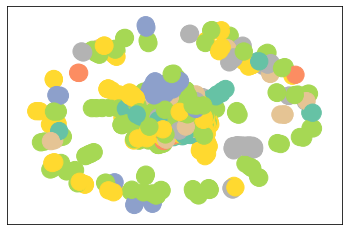

In [6]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,node_color=data.y, cmap="Set2")
plt.show()

In [7]:
# let's see the node feature vector of some random node (It's normalized):
print(f"6th node feature vecor : \n {data.x[5][1300:1350]}")

# nodes' labels :
print (f"labels : \n {data.y}")

# edges :
print(f" edges : \n {data.edge_index.t()}")

6th node feature vecor : 
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0769, 0.0000, 0.0000, 0.0000, 0.0000, 0.0769, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
labels : 
 tensor([3, 4, 4,  ..., 3, 3, 3])
 edges : 
 tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])


In [4]:
# Lets try an mlp model on this dataset (without considering edge (citation network))
## dimensionality reductuon on node features
# GNN : multiple conv then pooling architecture

# GCN MODEL

In [221]:
## GNN Model:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels ):
        super(GCN , self).__init__()
        torch.manual_seed(42)
        
        self.conv1=GCNConv(dataset.num_features , hidden_channels)
        self.conv2=GCNConv(hidden_channels , hidden_channels)
        self.conv3=GCNConv(hidden_channels , dataset.num_classes)
         
    
    def forward(self , x , edge_index):
        
        x = F.normalize(x)
        x = F.dropout(x , p=0.8, training = self.training)
                      
        x = self.conv1(x , edge_index)
        x = F.normalize(x)
        x = F.dropout(x , p=0.8, training = self.training)
        
        x = self.conv2(x , edge_index)
        x = x.relu()
        x = F.dropout(x , p=0.8 , training = self.training)
        
        x = self.conv3(x , edge_index)

        return x
    
model_GCN  = GCN(hidden_channels =16)
total_params = sum(p.numel() for p in model_GCN.parameters())
print(model)
print(f"Number of parameters : {total_params}")

device='cuda:0' if torch.cuda.is_available() else 'cpu'
model_GCN  = model_GCN .to(device)
data = data.to(device)

optimizer_GCN = torch.optim.Adam(model_GCN.parameters() , lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 7)
)
Number of parameters : 23335


In [222]:
from typing import List
from typing_extensions import Literal, TypedDict
import matplotlib.pyplot as plt

Stage = Literal["train" , "val" , "test"]

def accuracy(pred, target):
    return (pred == target).sum().item() / target.numel()

def train_step(model , data):
    model.train()
    optimizer_GCN.zero_grad()
    mask = data.train_mask
    logits = model(data.x , data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = criterion(logits , y)
    acc = accuracy(preds , y )
    loss.backward()
    optimizer_GCN.step()
    return loss.item() , acc

@torch.no_grad()
def eval_step(model , data , stage:Stage):
    model.eval()
    mask = getattr(data , f"{stage}_mask")
    logits = model(data.x, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = criterion(logits, y)
    acc = accuracy(preds , y )
    return loss.item() , acc

class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]
        
def train(model , data , max_epochs : int=2000 , 
          early_stopping : int=100,
         print_interval: int=10 , 
          verbose: bool=True
         ) -> HistoryDict:
    history={"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    
    for epoch in range(max_epochs):
        loss , acc = train_step(model,data)
        val_loss , val_acc = eval_step(model,data,"val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
            
    print("****************************************")
    test_loss, test_acc = eval_step(model, data, "test")
    
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

def plot_history(history: HistoryDict, title: str) -> None:
    plt.suptitle(title)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [223]:
MAX_EPOCHS = 20000
EARLY_STOPPING = 1000
PRINT_INTERVAL = 100
history = train(model_GCN , data, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING , print_interval=PRINT_INTERVAL)


Epoch: 0
----------
Train loss: 1.9594 | Train acc: 0.1214
  Val loss: 1.9461 |   Val acc: 0.1120

Epoch: 100
----------
Train loss: 1.5863 | Train acc: 0.5786
  Val loss: 1.5480 |   Val acc: 0.7600

Epoch: 200
----------
Train loss: 1.2522 | Train acc: 0.6857
  Val loss: 1.1825 |   Val acc: 0.7700

Epoch: 300
----------
Train loss: 0.9425 | Train acc: 0.7071
  Val loss: 0.9450 |   Val acc: 0.7720

Epoch: 400
----------
Train loss: 0.8462 | Train acc: 0.7571
  Val loss: 0.8385 |   Val acc: 0.7680

Epoch: 500
----------
Train loss: 0.8401 | Train acc: 0.7500
  Val loss: 0.7958 |   Val acc: 0.7680

Epoch: 600
----------
Train loss: 0.7954 | Train acc: 0.7357
  Val loss: 0.7972 |   Val acc: 0.7660

Epoch: 700
----------
Train loss: 0.8206 | Train acc: 0.6857
  Val loss: 0.7915 |   Val acc: 0.7720

Epoch: 800
----------
Train loss: 0.5671 | Train acc: 0.8143
  Val loss: 0.8172 |   Val acc: 0.7580

Epoch: 900
----------
Train loss: 0.5485 | Train acc: 0.8000
  Val loss: 0.8066 |   Val acc:

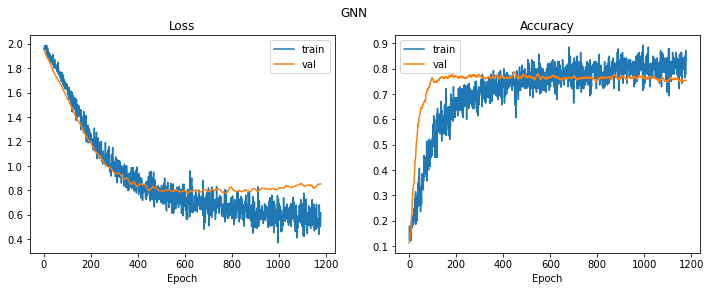

********************
 Test loss: 0.78 |  Test acc: 0.78


In [224]:
test_loss, test_acc = eval_step(model, data, "test")
plt.figure(figsize=(12, 4))
plot_history(history, "GNN")
plt.show()
print(20*"*")
print(f" Test loss: {test_loss:.2f} |  Test acc: {test_acc:.2f}")

# AUTOENCODER ON FEATURE VECTORS + GCN

In [247]:
class AE(torch.nn.Module):
    def __init__(self , latent_dim):
        super(AE,self).__init__()
        torch.manual_seed(42)
        self.encoder= torch.nn.Sequential(
            torch.nn.Linear(1433, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, latent_dim),
            torch.nn.ReLU()
        )
        self.decoder= torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1433),
            torch.nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded , decoded

model_ae=AE(latent_dim=8)
total_params=sum(p.numel() for p in model_ae.parameters())

print(model_ae)
print(f"Number of parameters : {total_params}")

device='cuda:0' if torch.cuda.is_available() else 'cpu'
model_ae = model_ae.to(device)

optimizer_ae = torch.optim.Adam(model_ae.parameters() , lr = 0.001)
criterion = torch.nn.MSELoss()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1433, bias=True)
    (3): ReLU()
  )
)
Number of parameters : 47585


In [248]:
def train():
      model_ae.train()
      optimizer_ae.zero_grad()  # Clear gradients.
      _ , out = model_ae(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.x[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer_ae.step()  # Update parameters based on gradients.
      return loss
    
def val():
      model_ae.eval()
      _ , out = model_ae(data.x)
      val_loss = criterion(out[data.val_mask] ,data.x[data.val_mask] )  # Derive ratio of correct predictions.
      return val_loss

def test():
      model_ae.eval()
      _ , out = model_ae(data.x)
      test_loss = criterion(out[data.test_mask] ,data.x[data.test_mask] )  # Derive ratio of correct predictions.
      return test_loss

for epoch in range(1, 2000):
    train_loss = train()
    val_loss = val()
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.8f} , Val Loss: {val_loss:.8f}')

Epoch: 001, Train Loss: 0.01721470 , Val Loss: 0.01664700
Epoch: 002, Train Loss: 0.01664614 , Val Loss: 0.01609883
Epoch: 003, Train Loss: 0.01609687 , Val Loss: 0.01556958
Epoch: 004, Train Loss: 0.01556657 , Val Loss: 0.01505884
Epoch: 005, Train Loss: 0.01505493 , Val Loss: 0.01456637
Epoch: 006, Train Loss: 0.01456170 , Val Loss: 0.01409190
Epoch: 007, Train Loss: 0.01408671 , Val Loss: 0.01363479
Epoch: 008, Train Loss: 0.01362922 , Val Loss: 0.01319430
Epoch: 009, Train Loss: 0.01318856 , Val Loss: 0.01276968
Epoch: 010, Train Loss: 0.01276385 , Val Loss: 0.01236021
Epoch: 011, Train Loss: 0.01235428 , Val Loss: 0.01196514
Epoch: 012, Train Loss: 0.01195916 , Val Loss: 0.01158385
Epoch: 013, Train Loss: 0.01157776 , Val Loss: 0.01121573
Epoch: 014, Train Loss: 0.01120956 , Val Loss: 0.01086015
Epoch: 015, Train Loss: 0.01085395 , Val Loss: 0.01051658
Epoch: 016, Train Loss: 0.01051044 , Val Loss: 0.01018450
Epoch: 017, Train Loss: 0.01017837 , Val Loss: 0.00986348
Epoch: 018, Tr

In [249]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.8f}')

Test Accuracy: 0.00005086


In [250]:
## getting new features from the decoder part : 1433 -> 8
new_x , _ = model_ae(data.x)
print(f" old feature vector shape : {data.x.shape} | new feature vector shape : {new_x.shape}")

 old feature vector shape : torch.Size([2708, 1433]) | new feature vector shape : torch.Size([2708, 8])


In [279]:
class GCN_AE(torch.nn.Module):
    def __init__(self, hidden_channels ):
        super(GCN_AE , self).__init__()
        torch.manual_seed(42)
        
        self.conv1=GCNConv(8 , 16)
        self.conv2=GCNConv(16 , 32)
        self.conv3=GCNConv(32 , 7)
         
    
    def forward(self , x , edge_index):
        
        x = F.normalize(x)
        x = F.dropout(x , p=0.8, training = self.training)
                      
        x = self.conv1(x , edge_index)
        x = F.normalize(x)
        x = F.dropout(x , p=0.2, training = self.training)
        
        x = self.conv2(x , edge_index)
        x = x.relu()
        x = F.dropout(x , p=0.2 , training = self.training)
        
        x = self.conv3(x , edge_index)

        return x
    
model_GCN_AE = GCN_AE(hidden_channels =16)
total_params = sum(p.numel() for p in model_GCN_AE.parameters())
print(model_GCN_AE)
print(f"Number of parameters : {total_params}")

device='cuda:0' if torch.cuda.is_available() else 'cpu'
model_GCN_AE = model_GCN_AE.to(device)

data = dataset[0]
data = data.to(device)
datax = new_x.to(device)

optimizer_GCN_AE = torch.optim.Adam(model_GCN_AE.parameters() , lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

GCN_AE(
  (conv1): GCNConv(8, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 7)
)
Number of parameters : 919


In [280]:
from typing import List
from typing_extensions import Literal, TypedDict
import matplotlib.pyplot as plt

Stage = Literal["train" , "val" , "test"]

def accuracy(pred, target):
    return (pred == target).sum().item() / target.numel()

def train_step(model ,data , dataX):
    model.train()
    optimizer_GCN_AE.zero_grad()
    mask = data.train_mask
    logits = model(dataX , data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = criterion(logits , y)
    acc = accuracy(preds , y )
    loss.backward(retain_graph=True)
    optimizer_GCN_AE.step()
    return loss.item() , acc

@torch.no_grad()
def eval_step(model ,data , dataX , stage:Stage):
    model.eval()
    mask = getattr(data , f"{stage}_mask")
    logits = model(dataX, data.edge_index)[mask]
    preds = logits.argmax(dim=1)
    y = data.y[mask]
    loss = criterion(logits, y)
    acc = accuracy(preds , y )
    return loss.item() , acc

class HistoryDict(TypedDict):
    loss: List[float]
    acc: List[float]
    val_loss: List[float]
    val_acc: List[float]
        
def train(model , data , dataX , max_epochs : int=2000 , 
          early_stopping : int=100,
         print_interval: int=10 , 
          verbose: bool=True
         ) -> HistoryDict:
    history={"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    
    for epoch in range(max_epochs):
        loss , acc = train_step(model,data , dataX)
        val_loss , val_acc = eval_step(model,data , dataX,"val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
            
    print("****************************************")
    test_loss, test_acc = eval_step(model, data ,dataX, "test")
    
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

def plot_history(history: HistoryDict, title: str) -> None:
    plt.suptitle(title)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()

In [281]:
MAX_EPOCHS = 200000
EARLY_STOPPING = 100000
PRINT_INTERVAL = 10000
history = train(model_GCN_AE, data , datax, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING , print_interval=PRINT_INTERVAL)


Epoch: 0
----------
Train loss: 1.9479 | Train acc: 0.1143
  Val loss: 1.9566 |   Val acc: 0.0580

Epoch: 10000
----------
Train loss: 1.7328 | Train acc: 0.2643
  Val loss: 1.9838 |   Val acc: 0.1680

Epoch: 20000
----------
Train loss: 1.6662 | Train acc: 0.3786
  Val loss: 1.9750 |   Val acc: 0.1900

Epoch: 30000
----------
Train loss: 1.6692 | Train acc: 0.2929
  Val loss: 2.0102 |   Val acc: 0.2120

Epoch: 40000
----------
Train loss: 1.5659 | Train acc: 0.4214
  Val loss: 2.0269 |   Val acc: 0.2360

Epoch: 50000
----------
Train loss: 1.5472 | Train acc: 0.4071
  Val loss: 2.0612 |   Val acc: 0.2360

Epoch: 60000
----------
Train loss: 1.5859 | Train acc: 0.3714
  Val loss: 2.0746 |   Val acc: 0.2280

Epoch: 70000
----------
Train loss: 1.5412 | Train acc: 0.4500
  Val loss: 2.0975 |   Val acc: 0.2280

Epoch: 80000
----------
Train loss: 1.5442 | Train acc: 0.3929
  Val loss: 2.1164 |   Val acc: 0.2340

Epoch: 90000
----------
Train loss: 1.5289 | Train acc: 0.4000
  Val loss: 2

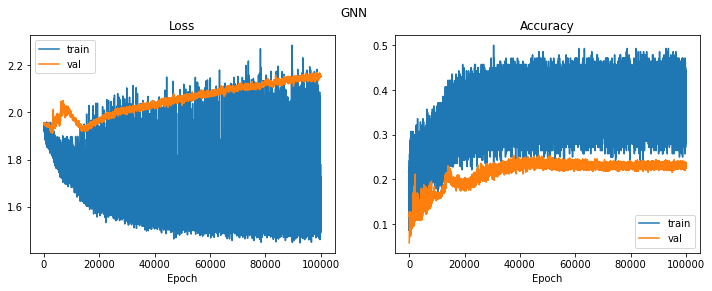

********************
 Test loss: 2.12 |  Test acc: 0.21


In [282]:
test_loss, test_acc = eval_step(model_GCN_AE, data , datax, "test")
plt.figure(figsize=(12, 4))
plot_history(history, "GNN")
plt.show()
print(20*"*")
print(f" Test loss: {test_loss:.2f} |  Test acc: {test_acc:.2f}")